# Collaborative filtering project

In this project, the task is to create a paper recommendation system. The system consists of 10,000 scientists and 1,000 papers. Scientists give ratings between 1–5 to the papers that they read. Since not all scientists have read every paper, we only have a limited amount of observations of these ratings. Additionally, each scientist has a wishlist of papers that they would like to read in the future. Your task is to fill in the missing observations using the provided rating and wishlist data, such that we can recommend papers to scientists that we expect them to rate highly.

More specifically, there are three data sources:
 - `train_tbr.csv` containing wishlist data.
 - `train_ratings.csv` containing observed rating data.
 - `sample_submission.csv` containing (scientist, paper) pairs that have to be rated for the evaluation of your method.

The data is available at `/cluster/courses/cil/collaborative_filtering/data` and an environment has been prepared for you at `/cluster/courses/cil/envs/collaborative_filtering`. You can activate the environment in your shell by running:
```bash
conda activate /cluster/courses/cil/envs/collaborative_filtering
```
If you wish to use notebooks on the cluster, you need to set the Environment path to `/cluster/courses/cil/envs/collaborative_filtering/bin` and load the `cuda/12.6` module.

**Evaluation**: Your models are evaluated using the root mean-squared error (RMSE) metric. Your grade is determined by a linear interpolation between the easy (grade 4) and hard (grade 6) baselines.

**Rules**: You are only allowed to use the data provided in `train_tbr.csv` and `train_ratings.csv` to make your predictions of `sample_submission.csv`. You are not allowed to use external data sources. But, you are allowed to use pre-trained models, as long as they are available publicly. Furthermore, no external API calls are allowed, except for downloading the weights of pre-trained models.

**We will verify your code for plagiarism and using solutions from previous years.**

[Link to Kaggle competition](https://www.kaggle.com/competitions/ethz-cil-collaborative-filtering-2025)


In [1]:
from typing import Tuple, Callable

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os

Make sure that results are reproducible by using a seed.

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Helper functions

In [3]:
DATA_DIR = "/cluster/courses/cil/collaborative_filtering/data"


def read_data_df() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Reads in data and splits it into training and validation sets with a 75/25 split."""
    
    df = pd.read_csv(os.path.join(DATA_DIR, "train_ratings.csv"))

    # Split sid_pid into sid and pid columns
    df[["sid", "pid"]] = df["sid_pid"].str.split("_", expand=True)
    df = df.drop("sid_pid", axis=1)
    df["sid"] = df["sid"].astype(int)
    df["pid"] = df["pid"].astype(int)
    
    # Split into train and validation dataset
    train_df, valid_df = train_test_split(df, test_size=0.25)
    return train_df, valid_df


def read_data_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns matrix view of the training data, where columns are scientists (sid) and
    rows are papers (pid)."""

    return df.pivot(index="sid", columns="pid", values="rating").values


def evaluate(valid_df: pd.DataFrame, pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    """
    Inputs:
        valid_df: Validation data, returned from read_data_df for example.
        pred_fn: Function that takes in arrays of sid and pid and outputs their rating predictions.

    Outputs: Validation RMSE
    """
    
    preds = pred_fn(valid_df["sid"].values, valid_df["pid"].values)
    return root_mean_squared_error(valid_df["rating"].values, preds)


def make_submission(pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray], filename: os.PathLike):
    """Makes a submission CSV file that can be submitted to kaggle.

    Inputs:
        pred_fn: Function that takes in arrays of sid and pid and outputs a score.
        filename: File to save the submission to.
    """
    
    df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

    # Get sids and pids
    sid_pid = df["sid_pid"].str.split("_", expand=True)
    sids = sid_pid[0]
    pids = sid_pid[1]
    sids = sids.astype(int).values
    pids = pids.astype(int).values
    
    df["rating"] = pred_fn(sids, pids)
    df.to_csv(filename, index=False)

In [4]:
train_df, valid_df = read_data_df()

In [5]:
print(train_df.tail())

        rating   sid  pid
110268       5   929  783
259178       4  2192  558
131932       4  1109   64
671155       4  5771  410
121958       5  1027   57


In [6]:
print(read_data_matrix(train_df))

[[nan nan nan ... nan nan nan]
 [nan  5. nan ... nan nan  3.]
 [nan  4.  3. ... nan nan nan]
 ...
 [nan  3. nan ... nan nan nan]
 [nan  3. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


## Singular value decomposition

For the first method in this introduction, we will make use of the singular value decomposition (SVD) to construct the optimal rank-$k$ approximation (when measuring the Frobenius norm as error), according to the Eckart-Young theorem. Since the matrix needs to be fully observed in order to make use of SVD, we need to impute the missing values. In this case, we impute values with $3$.

In [7]:
def impute_values(mat: np.ndarray) -> np.ndarray:
    return np.nan_to_num(mat, nan=3.0)

In [8]:
train_df, valid_df = read_data_df()
train_mat = read_data_matrix(train_df)
train_mat = impute_values(train_mat)

### Singular value spectrum

In order to assess which rank $k$ to use for the reconstruction matrix, we look at the spectrum of singular values and look for the "elbow". In this case, we will use $k=2$.

In [9]:
print(f"Train matrix shape: {train_df.shape}")
print(f"Validation matrix shape: {valid_df.shape}")
print(f"Train matrix head: \n {train_df.head}")
print(f"Validation matrix head: \n {valid_df.head}")

Train matrix shape: (846140, 3)
Validation matrix shape: (282047, 3)
Train matrix head: 
 <bound method NDFrame.head of          rating   sid  pid
663940        4  5708  660
93337         3   785  203
114265        4   963  754
318446        5  2706   62
1068983       3  9416  791
...         ...   ...  ...
79568         3   668  517
135553        4  1141   36
1101280       5  9729  596
1044863       5  9183  173
299091        3  2537  668

[846140 rows x 3 columns]>
Validation matrix head: 
 <bound method NDFrame.head of         rating   sid  pid
872090       3  7581    2
848396       4  7364  300
705686       5  6071   62
222418       1  1878  358
29179        4   240  905
...        ...   ...  ...
872114       3  7581  183
720226       4  6203  683
106367       5   896   63
679268       3  5837  315
414323       3  3540  222

[282047 rows x 3 columns]>


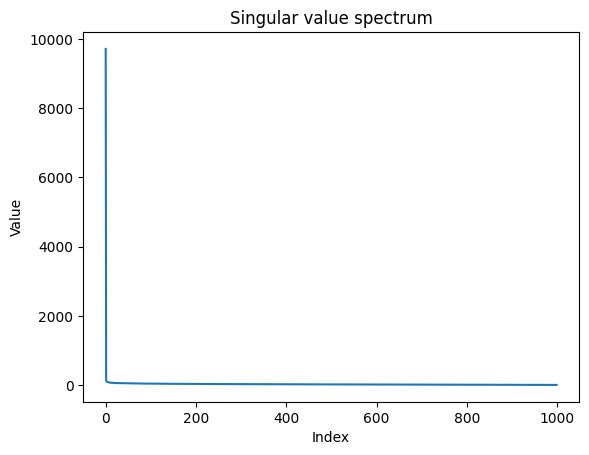

In [10]:
singular_values = np.linalg.svd(train_mat, compute_uv=False, hermitian=False)
plt.plot(singular_values)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Singular value spectrum")
plt.show()

In [11]:
def opt_rank_k_approximation(m: np.ndarray, k: int):
    """Returns the optimal rank-k reconstruction matrix, using SVD."""
    
    assert 0 < k <= np.min(m.shape), f"The rank must be in [0, min(m, n)]"
    
    U, S, Vh = np.linalg.svd(m, full_matrices=False)
    
    U_k = U[:, :k]
    S_k = S[:k]
    Vh_k = Vh[:k]
    
    return np.dot(U_k * S_k, Vh_k)


def matrix_pred_fn(train_recon: np.ndarray, sids: np.ndarray, pids: np.ndarray) -> np.ndarray:
    """
    Input:
        train_recon: (M, N) matrix with predicted values for every (sid, pid) pair.
        sids: (D,) vector with integer scientist IDs.
        pids: (D,) vector with integer paper IDs.
        
    Outputs: (D,) vector with predictions.
    """
    
    return train_recon[sids, pids]

We first obtain the optimal rank-$k$ approximation of the training matrix.

In [12]:
train_recon = opt_rank_k_approximation(train_mat, k=2)

Then, the values of this matrix reconstruction are the predictions for all (sid, pid)-pairs.

In [13]:
pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)

# Evaluate on validation data
val_score = evaluate(valid_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 1.207


In [14]:
make_submission(pred_fn, "submissions/svd_submission.csv")

## Learned embeddings

Next, we will take a machine learning view of the problem. To each scientist and paper, we assign a $d$-dimensional embedding and we predict the rating that the scientist gives the paper to be their dot product. More formally, let $\vec{s}_i$ be a scientist embedding and $\vec{p}_j$ be a paper embedding. Then, we make the following rating prediction for this pair: $$\tilde{r}_{ij} = \langle \vec{s}_i, \vec{p}_j \rangle.$$ We view these embeddings as our learnable parameters and train them as we would any other model using the squared error loss function: $$\ell(\theta) = \frac{1}{2} |\langle \vec{s}_i, \vec{p}_j \rangle - r_{ij}|^2,$$ where $\theta = \{ \vec{s}_i \}_{i=1}^n \cup \{ \vec{p}_j \}_{j=1}^m$. The following is an implementation of this method.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [16]:
class EmbeddingDotProductModel(nn.Module):
    def __init__(self, num_scientists: int, num_papers: int, dim: int):
        super().__init__()

        # Assign to each scientist and paper an embedding
        self.scientist_emb = nn.Embedding(num_scientists, dim)
        self.paper_emb = nn.Embedding(num_papers, dim)
        
    def forward(self, sid: torch.Tensor, pid: torch.Tensor) -> torch.Tensor:
        """
        Inputs:
            sid: [B,], int
            pid: [B,], int
        
        Outputs: [B,], float
        """

        # Per-pair dot product
        return torch.sum(self.scientist_emb(sid) * self.paper_emb(pid), dim=-1)

Set $d=32$.

In [17]:
# Define model (10k scientists, 1k papers, 32-dimensional embeddings) and optimizer
model = EmbeddingDotProductModel(10_000, 1_000, 32).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
def get_dataset(df: pd.DataFrame) -> torch.utils.data.Dataset:
    """Conversion from pandas data frame to torch dataset."""
    
    sids = torch.from_numpy(df["sid"].to_numpy())
    pids = torch.from_numpy(df["pid"].to_numpy())
    ratings = torch.from_numpy(df["rating"].to_numpy()).float()
    return torch.utils.data.TensorDataset(sids, pids, ratings)

In [19]:
train_dataset = get_dataset(train_df)
valid_dataset = get_dataset(valid_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

Training loop, which we run for 5 epochs.

In [20]:
NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    # Train model for an epoch
    total_loss = 0.0
    total_data = 0
    model.train()
    for sid, pid, ratings in train_loader:
        # Move data to GPU
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        # Make prediction and compute loss
        pred = model(sid, pid)
        loss = F.mse_loss(pred, ratings)

        # Compute gradients w.r.t. loss and take a step in that direction
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of running loss
        total_data += len(sid)
        total_loss += len(sid) * loss.item()

    # Evaluate model on validation data
    total_val_mse = 0.0
    total_val_data = 0
    model.eval()
    for sid, pid, ratings in valid_loader:
        # Move data to GPU
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        # Clamp predictions in [1,5], since all ground-truth ratings are
        pred = model(sid, pid).clamp(1, 5)
        mse = F.mse_loss(pred, ratings)

        # Keep track of running metrics
        total_val_data += len(sid)
        total_val_mse += len(sid) * mse.item()

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train loss={total_loss / total_data:.3f}, Valid RMSE={(total_val_mse / total_val_data) ** 0.5:.3f}")

[Epoch 1/5] Train loss=34.174, Valid RMSE=2.649
[Epoch 2/5] Train loss=16.796, Valid RMSE=2.242
[Epoch 3/5] Train loss=3.175, Valid RMSE=1.156
[Epoch 4/5] Train loss=1.029, Valid RMSE=0.986
[Epoch 5/5] Train loss=0.878, Valid RMSE=0.954


As we can see, this method already provides an improvement on the validation dataset over the naive SVD method.

In [21]:
pred_fn = lambda sids, pids: model(torch.from_numpy(sids).to(device), torch.from_numpy(pids).to(device)).clamp(1, 5).cpu().numpy()

# Evaluate on validation data
with torch.no_grad():
    val_score = evaluate(valid_df, pred_fn)

print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 0.954


In [22]:
with torch.no_grad():
    make_submission(pred_fn, "submissions/learned_embedding_submission.csv")

## Outlook

To further improve the score, students can make use of the information in `train_tbr.csv`, which contains the papers that scientists want to read. Furthermore, students can look into more modern collaborative filtering methods and techniques.

Have fun :)

## Iterative SVD

In [23]:
def impute_values_mean(mat: np.ndarray) -> np.ndarray:
    return np.nan_to_num(mat, nan=np.nanmean(mat))

In [24]:
train_df, valid_df = read_data_df()
train_mat = read_data_matrix(train_df)
observed_mask = ~np.isnan(train_mat)
train_mat = impute_values_mean(train_mat)

In [25]:
max_iter = 50
k = 2
tol = 1e-4

for iteration in range(max_iter):
    train_mat_reconstructed = opt_rank_k_approximation(train_mat, k)
    
    # Update only missing values
    new_train_mat = train_mat.copy()
    new_train_mat[~observed_mask] = train_mat_reconstructed[~observed_mask]
    
    # Check convergence: compute change on missing entries
    diff = np.linalg.norm(new_train_mat[~observed_mask] - train_mat[~observed_mask])
    if iteration % 5 == 0:
        print(f"Iteration {iteration}: diff = {diff}")  # optionally monitor progress
    if diff < tol:
        break
    train_mat = new_train_mat

Iteration 0: diff = 154.97935464818312
Iteration 5: diff = 79.0508158239096
Iteration 10: diff = 51.523547568776124
Iteration 15: diff = 36.464002735829794
Iteration 20: diff = 27.145072153827787
Iteration 25: diff = 21.007244628943045
Iteration 30: diff = 16.792048696567594
Iteration 35: diff = 13.789365724521977
Iteration 40: diff = 11.574714105797074
Iteration 45: diff = 9.887230759885245


In [26]:
pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)

# Evaluate on validation data
val_score = evaluate(valid_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 1.202


In [27]:
make_submission(pred_fn, "submissions/iter_svd_submission.csv")

## SVDPP

Notes:
- This notebook is mainly to explore different algorithms and test the implementation of training and evaluation functions.
- To crteate submissions, python scripts were used and run as jobs on the cluster.

In [28]:
def train_svdpp(train_df, num_factors=20, lr=0.005, reg=0.02, n_epochs=20):
    """
    Train a fast, NumPy‐only SVD++ on train_df (with columns 'sid','pid','rating').
    """
    # 1) remap IDs to 0…N–1
    sids = train_df['sid'].unique()
    pids = train_df['pid'].unique()
    user2ind = {sid: i for i, sid in enumerate(sids)}
    item2ind = {pid: i for i, pid in enumerate(pids)}
    n_users, n_items = len(sids), len(pids)

    # 2) build index arrays once
    user_arr   = train_df['sid'].map(user2ind).to_numpy(dtype=np.int32)
    item_arr   = train_df['pid'].map(item2ind).to_numpy(dtype=np.int32)
    rating_arr = train_df['rating'].to_numpy(dtype=np.float32)

    # 3) global mean as float32
    mu = np.float32(rating_arr.mean())

    # 4) init parameters (float32)
    b_u = np.zeros(n_users, np.float32)
    b_i = np.zeros(n_items, np.float32)
    p   = np.random.normal(0, 0.1, (n_users, num_factors)).astype(np.float32)
    q   = np.random.normal(0, 0.1, (n_items, num_factors)).astype(np.float32)
    y   = np.random.normal(0, 0.1, (n_items, num_factors)).astype(np.float32)

    # 5) build implicit lists
    implicit = {u: [] for u in range(n_users)}
    for u, i in zip(user_arr, item_arr):
        implicit[u].append(i)
    Nu_list  = [np.array(implicit[u], dtype=np.int32) for u in range(n_users)]
    Nu_count = np.array([len(a) for a in Nu_list], dtype=np.int32)
    sqrt_Nu  = np.where(Nu_count>0, np.sqrt(Nu_count, dtype=np.float32), 1.0)

    # 6) precompute y_sum[u] = sum_j y[j] / sqrt_Nu[u]
    y_sum = np.zeros((n_users, num_factors), np.float32)
    for u in range(n_users):
        if Nu_count[u]:
            y_sum[u] = y[Nu_list[u]].sum(0) / sqrt_Nu[u]

    # 7) SGD loop (vectorized implicit updates)
    n_ratings = rating_arr.shape[0]
    for epoch in range(n_epochs):
        perm = np.random.permutation(n_ratings)
        for idx in perm:
            u = user_arr[idx]; i = item_arr[idx]; r = rating_arr[idx]
            imp = y_sum[u]                      # (f,)
            pred = mu + b_u[u] + b_i[i] + q[i].dot(p[u] + imp)
            err  = r - pred

            # biases & factors
            b_u[u] += lr * (err - reg * b_u[u])
            b_i[i] += lr * (err - reg * b_i[i])
            p_old   = p[u].copy()
            p[u]   += lr * (err * q[i]   - reg * p[u])
            q[i]   += lr * (err * (p_old + imp) - reg * q[i])

            # fast implicit update (matches Eq. 15 exactly)
            if Nu_count[u]:
                coeff = lr * err / sqrt_Nu[u]
                idxs  = Nu_list[u]
                yj    = y[idxs]
                y[idxs] = yj + coeff * q[i] - lr * reg * yj
                # update y_sum with Δy_sum = lr*err*q[i] - lr*reg*y_sum[u]
                y_sum[u] = y_sum[u] + lr * err * q[i] - lr * reg * y_sum[u]

        print(f"Epoch {epoch+1}/{n_epochs} done.")

    return {
        'mu':mu, 'b_u':b_u, 'b_i':b_i,
        'p':p,   'q':q,   'y':y,
        'user2ind':user2ind, 'item2ind':item2ind,
        'implicit':implicit, 'num_factors':num_factors
    }


def svdpp_pred(model, sids, pids):
    """
    Prediction function for trained SVD++ model, with correct baseline fallback.
    """
    mu = model['mu']
    user2ind = model['user2ind']
    item2ind = model['item2ind']
    b_u = model['b_u']
    b_i = model['b_i']
    p = model['p']
    q = model['q']
    y = model['y']
    num_factors = model['num_factors']
    implicit = model['implicit']
    
    preds = []
    for sid, pid in zip(sids, pids):
        # start with any known baseline terms
        pred = mu
        if sid in user2ind:
            u = user2ind[sid]
            pred += b_u[u]
        if pid in item2ind:
            i = item2ind[pid]
            pred += b_i[i]
        # only add the latent term if both user and item are known
        if (sid in user2ind) and (pid in item2ind):
            Nu = implicit[u]
            sqrt_Nu = np.sqrt(len(Nu)) if Nu else 1.0
            imp_sum = np.sum(y[Nu, :], axis=0) / sqrt_Nu if Nu else np.zeros(num_factors)
            pred += np.dot(q[i], p[u] + imp_sum)
        preds.append(pred)
    # convert to ndarray and clip to [1,5]
    preds = np.array(preds, dtype=np.float32)
    return np.clip(preds, 1.0, 5.0)

### Adjust the pred function to add a fixed score amount if scientist want to read the paper

In [8]:
# Load TBR data and build a lookup set
tbr_df = pd.read_csv(os.path.join(DATA_DIR, "train_tbr.csv"))  # columns: sid, pid
tbr_pairs = set(zip(tbr_df['sid'], tbr_df['pid']))

# Wrap existing pred fn to apply the boost
def svdpp_pred_with_tbr_and_cap(model, sids, pids, boost_pairs, boost=0.5, cap=5.0):
    # 1) get base SVD++ predictions
    base_preds = svdpp_pred(model, sids, pids)
    
    # 2) add boost for any (sid, pid) in the “to‐be‐read” set
    for idx, (sid, pid) in enumerate(zip(sids, pids)):
        if (sid, pid) in boost_pairs:
            base_preds[idx] += boost
    
    # 3) cap at the rating ceiling
    np.clip(base_preds, None, cap, out=base_preds)
    
    return base_preds

### Main routine for training and evaluation 

In [30]:
# Read training and validation data using provided helper function.
train_df, valid_df = read_data_df()

In [31]:
# Train the SVD++ model a single epoch to assess running time
model = train_svdpp(train_df, num_factors=20, lr=0.005, reg=0.02, n_epochs=1) # ~30s

Epoch 1/1 done.


In [32]:
# Train the SVD++ model (adjust hyperparameters as needed).
# Best hyperparameter configurations found include:
# fac=50,  lr=0.005, reg=0.05, ep=45
# fac=50,  lr=0.01,  reg=0.05, ep=20
# fac=100, lr=0.01,  reg=0.05, ep=20
# fac=20,  lr=0.005, reg=0.02, ep=20
model = train_svdpp(train_df, num_factors=50, lr=0.005, reg=0.05, n_epochs=10)

Epoch 1/10 done.
Epoch 2/10 done.
Epoch 3/10 done.
Epoch 4/10 done.
Epoch 5/10 done.
Epoch 6/10 done.
Epoch 7/10 done.
Epoch 8/10 done.
Epoch 9/10 done.
Epoch 10/10 done.


In [33]:
# Define the prediction function for evaluation/submission.
svdpp_fn = lambda sids, pids: svdpp_pred(model, sids, pids)

# Evaluate on validation data.
val_rmse = evaluate(valid_df, svdpp_fn)
print(f"Validation RMSE: {val_rmse:.3f}")

Validation RMSE: 0.881


### Prediction with adding of boost for paper read-list

In [34]:
# Define a new eval‐able function
svdpp_tbr_cap_fn = lambda sids, pids: svdpp_pred_with_tbr_and_cap(
    model, sids, pids, tbr_pairs, boost=0.5, cap=5.0
)

# Run usual evaluation
val_rmse_tbr = evaluate(valid_df, svdpp_tbr_cap_fn)
print(f"Validation RMSE (with TBR boost): {val_rmse_tbr:.3f}")

Validation RMSE (with TBR boost): 0.881


Note: For actual submissions, we should train on the entire data available

In [41]:
# How many of the validation pairs are actually in the TBR set?
val_pairs = set(zip(valid_df['sid'], valid_df['pid']))
n_overlap = len(val_pairs & tbr_pairs)
print(f"Validation hits in TBR: {n_overlap} / {len(val_pairs)}")

# Or in your pred-fn itself, count how many boosts we actually apply:
count = 0
for sid,pid in zip(valid_df['sid'], valid_df['pid']):
    if (sid,pid) in tbr_pairs:
        count += 1
print("Boost applied to", count, "records")

Validation hits in TBR: 0 / 282047
Boost applied to 0 records


In [9]:
# Read submission dataset
df_sub = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

# Split sid_pid into sid and pid columns
df_sub[["sid", "pid"]] = df_sub["sid_pid"].str.split("_", expand=True)
df_sub = df_sub.drop("sid_pid", axis=1)
df_sub["sid"] = df_sub["sid"].astype(int)
df_sub["pid"] = df_sub["pid"].astype(int)

# How many of the submission pairs are actually in the TBR set?
sub_pairs = set(zip(df_sub['sid'], df_sub['pid']))
n_overlap = len(sub_pairs & tbr_pairs)
print(f"Submission hits in TBR: {n_overlap} / {len(sub_pairs)}")

# Or in your pred-fn itself, count how many boosts we actually apply:
count = 0
for sid,pid in zip(df_sub['sid'], df_sub['pid']):
    if (sid,pid) in tbr_pairs:
        count += 1
print("Boost applied to", count, "records")

Submission hits in TBR: 0 / 1128187
Boost applied to 0 records


## Full Hyprid method

In [13]:
from collections import defaultdict


def compute_baseline(user_arr, item_arr, rating_arr, n_users, n_items, reg=20.0, n_epochs=10, lr=0.005):
    """
    Compute global mean mu, user biases bu, and item biases bi.
    Solves min_bu,bi sum((r_ui - mu - bu_u - bi_i)^2) + reg*(bu^2 + bi^2).
    """
    mu = np.mean(rating_arr, dtype=np.float32)
    bu = np.zeros(n_users, np.float32)
    bi = np.zeros(n_items, np.float32)
    for _ in range(n_epochs):
        for u, i, r in zip(user_arr, item_arr, rating_arr):
            pred = mu + bu[u] + bi[i]
            err = r - pred
            bu[u] += lr * (err - reg * bu[u])
            bi[i] += lr * (err - reg * bi[i])
    return mu, bu, bi


def compute_item_neighbors(user_arr, item_arr, rating_arr, mu, bu, bi, n_items, k=300, shrink=100.0):
    """
    Compute top-k neighbors for each item using shrunk Pearson correlation on residuals.
    Returns: dict i -> list of neighbor item indices (length k or fewer).
    """
    # Build item->(user->residual) map
    item_users = defaultdict(dict)
    for u, i, r in zip(user_arr, item_arr, rating_arr):
        resid = r - (mu + bu[u] + bi[i])
        item_users[i][u] = resid

    neighbors = {}
    for i in range(n_items):
        sims = []
        users_i = item_users[i]
        keys_i = set(users_i.keys())
        mean_i = 0.0  # zero-mean residuals
        var_i = sum(v*v for v in users_i.values())
        for j in range(n_items):
            if j == i:
                continue
            users_j = item_users[j]
            common = keys_i & set(users_j.keys())
            n_common = len(common)
            if n_common < 2:
                continue
            # compute covariance & variances
            cov = sum(users_i[u] * users_j[u] for u in common)
            var_j = sum(users_j[u]*users_j[u] for u in common)
            denom = np.sqrt(var_i * var_j)
            if denom <= 0:
                continue
            pearson = cov / denom
            shrunk = (n_common / (n_common + shrink)) * pearson
            sims.append((shrunk, j))
        # pick top-k
        sims.sort(reverse=True, key=lambda x: x[0])
        neighbors[i] = [j for _, j in sims[:k]]
    return neighbors


def train_hybrid(train_df, valid_df=None,
                 num_factors=20,
                 lr1=0.007, lr2=0.007, lr3=0.001,
                 reg1=0.005, reg2=0.015, reg3=0.015,
                 k=300, shrink=100.0,
                 n_epochs=30, eval_interval=5,
                 seed=42):
    """
    Train the full hybrid model (baseline + SVD++ + neighborhood).
    Returns the model dict.
    """
    np.random.seed(seed)
    # remap IDs
    sids = train_df['sid'].unique()
    pids = train_df['pid'].unique()
    user2ind = {sid: u for u, sid in enumerate(sids)}
    item2ind = {pid: i for i, pid in enumerate(pids)}
    n_users, n_items = len(sids), len(pids)

    # index arrays
    user_arr   = train_df['sid'].map(user2ind).values.astype(np.int32)
    item_arr   = train_df['pid'].map(item2ind).values.astype(np.int32)
    rating_arr = train_df['rating'].values.astype(np.float32)

    # 1. Baseline
    mu, bu, bi = compute_baseline(user_arr, item_arr, rating_arr,
                                   n_users, n_items,
                                   reg=reg1, n_epochs=10, lr=lr1)

    # 2. Implicit feedback
    implicit = {u: [] for u in range(n_users)}
    for u, i in zip(user_arr, item_arr):
        implicit[u].append(i)
    Nu_list = [np.array(implicit[u], dtype=np.int32) for u in range(n_users)]
    Nu_count = np.array([len(l) for l in Nu_list], dtype=np.int32)
    sqrt_Nu = np.where(Nu_count>0, np.sqrt(Nu_count, dtype=np.float32), 1.0)

    # 3. Neighborhood structure
    neighbors = compute_item_neighbors(user_arr, item_arr, rating_arr,
                                       mu=mu, bu=bu, bi=bi,
                                       n_items=n_items,
                                       k=k, shrink=shrink)

    # 4. Initialize parameters
    p = np.random.normal(0, 0.1, (n_users, num_factors)).astype(np.float32)
    q = np.random.normal(0, 0.1, (n_items, num_factors)).astype(np.float32)
    y = np.random.normal(0, 0.1, (n_items, num_factors)).astype(np.float32)
    # w and c: dict i -> array(len(neighbors[i]))
    w = {i: np.zeros(len(neighbors[i]), np.float32) for i in range(n_items)}
    c = {i: np.zeros(len(neighbors[i]), np.float32) for i in range(n_items)}

    # 5. Precompute y_sum per user
    y_sum = np.zeros((n_users, num_factors), np.float32)
    for u in range(n_users):
        if Nu_count[u] > 0:
            y_sum[u] = y[Nu_list[u]].sum(axis=0) / sqrt_Nu[u]

    # 6. Build user->item->rating map for residual lookups
    ratings_by_user = [dict() for _ in range(n_users)]
    for u, i, r in zip(user_arr, item_arr, rating_arr):
        ratings_by_user[u][i] = r

    # 7. SGD loop
    n_ratings = rating_arr.shape[0]
    for epoch in range(1, n_epochs+1):
        perm = np.random.permutation(n_ratings)
        for idx in perm:
            u, i, r = user_arr[idx], item_arr[idx], rating_arr[idx]
            # SVD++ component
            imp = y_sum[u]
            svdpp_term = q[i].dot(p[u] + imp)
            # Neighborhood terms
            Rk = [j for j in neighbors[i] if j in ratings_by_user[u]]
            Nk = [j for j in neighbors[i] if j in implicit[u]]
            sqrt_Rk = np.sqrt(len(Rk), dtype=np.float32) if Rk else 1.0
            sqrt_Nk = np.sqrt(len(Nk), dtype=np.float32) if Nk else 1.0
            neigh_explicit = 0.0
            for idx_j, j in enumerate(Rk):
                neigh_explicit += (ratings_by_user[u][j] - (mu + bu[u] + bi[j])) * w[i][idx_j]
            neigh_explicit /= sqrt_Rk
            neigh_implicit = 0.0
            for idx_j, j in enumerate(Nk):
                neigh_implicit += c[i][idx_j]
            neigh_implicit /= sqrt_Nk

            pred = mu + bu[u] + bi[i] + svdpp_term + neigh_explicit + neigh_implicit
            err  = r - pred

            # update baseline terms
            bu[u] += lr1 * (err - reg1 * bu[u])
            bi[i] += lr1 * (err - reg1 * bi[i])
            
            # update SVD++ factors
            p_u_old = p[u].copy()
            p[u] += lr2 * (err * q[i]   - reg2 * p[u])
            q[i] += lr2 * (err * (p_u_old + imp) - reg2 * q[i])
            if Nu_count[u] > 0:
                coeff = lr2 * err / sqrt_Nu[u]
                for j in Nu_list[u]:
                    y[j] += coeff * q[i] - lr2 * reg2 * y[j]
                # update y_sum[u]
                y_sum[u] = y[Nu_list[u]].sum(axis=0) / sqrt_Nu[u]

            # update neighborhood weights
            for idx_j, j in enumerate(Rk):
                basel_res = ratings_by_user[u][j] - (mu + bu[u] + bi[j])
                w[i][idx_j] += lr3 * (err / sqrt_Rk * basel_res - reg3 * w[i][idx_j])
            for idx_j, j in enumerate(Nk):
                c[i][idx_j] += lr3 * (err / sqrt_Nk - reg3 * c[i][idx_j])

        # end of epoch
        print(f"Epoch {epoch}/{n_epochs} completed.")
        if valid_df is not None and (epoch % eval_interval == 0):
            model = {
                'mu': mu, 'b_u': bu, 'b_i': bi,
                'p': p, 'q': q, 'y': y,
                'w': w, 'c': c,
                'user2ind': user2ind, 'item2ind': item2ind,
                'implicit': implicit, 'neighbors': neighbors,
                'num_factors': num_factors
            }
            preds = hybrid_pred(model,
                                valid_df['sid'].values,
                                valid_df['pid'].values)
            rmse = np.sqrt(((valid_df['rating'].values - preds)**2).mean())
            print(f"Validation RMSE: {rmse:.4f}")

    # return final model
    return {
        'mu': mu, 'b_u': bu, 'b_i': bi,
        'p': p, 'q': q, 'y': y,
        'w': w, 'c': c,
        'user2ind': user2ind, 'item2ind': item2ind,
        'implicit': implicit, 'neighbors': neighbors,
        'num_factors': num_factors
    }


def hybrid_pred(model, sids, pids, min_rating=1.0, max_rating=5.0):
    """
    Prediction for hybrid model (Eq. 16).
    """
    mu = model['mu']
    b_u, b_i = model['b_u'], model['b_i']
    p, q, y = model['p'], model['q'], model['y']
    w, c = model['w'], model['c']
    user2ind = model['user2ind']
    item2ind = model['item2ind']
    implicit = model['implicit']
    neighbors = model['neighbors']
    num_factors = model['num_factors']

    preds = []
    for sid, pid in zip(sids, pids):
        if sid in user2ind and pid in item2ind:
            u = user2ind[sid]; i = item2ind[pid]
            # SVD++ term
            Nu = implicit[u]
            sqrt_Nu = np.sqrt(len(Nu)) if Nu else 1.0
            imp = np.sum(y[Nu], axis=0) / sqrt_Nu if Nu else np.zeros(num_factors)
            svdpp_term = q[i].dot(p[u] + imp)
            # neighborhood
            Rk = [j for j in neighbors[i] if j in implicit[u]]
            Nk = Rk  # since N(u)=R(u)
            sqrt_Rk = np.sqrt(len(Rk)) if Rk else 1.0
            sqrt_Nk = np.sqrt(len(Nk)) if Nk else 1.0
            neigh_explicit = sum((model['implicit_ratings'][u][j] - (mu + b_u[u] + b_i[j])) * w[i][idx]
                                 for idx, j in enumerate(Rk)) / sqrt_Rk
            neigh_implicit = sum(c[i][idx] for idx, j in enumerate(Nk)) / sqrt_Nk

            pred = mu + b_u[u] + b_i[i] + svdpp_term + neigh_explicit + neigh_implicit
        else:
            pred = mu + 0 + 0
        # clip
        preds.append(np.clip(pred, min_rating, max_rating))

    return np.array(preds, dtype=np.float32)


In [ ]:
# Train the hybrid model a single epoch to assess running time
hybrid_model = train_hybrid(train_df, valid_df=None,
                 num_factors=50,
                 lr1=0.007, lr2=0.007, lr3=0.001,
                 reg1=0.005, reg2=0.015, reg3=0.015,
                 k=300, shrink=100.0,
                 n_epochs=1, eval_interval=5,
                 seed=42) # ~30min

## Hybrid including to-be-read list

In [21]:
def train_hybrid_with_tbr(train_df, wish_df, valid_df=None,
                         num_factors=20,
                         lr1=0.007, lr2=0.007, lr3=0.001,
                         reg1=0.005, reg2=0.015, reg3=0.015,
                         k=300, shrink=100.0,
                         n_epochs=30, eval_interval=5,
                         seed=42):
    """
    Train the extended hybrid model with additional "wish-list" feedback.
    Incorporates baseline + SVD++ + neighborhood + wish-list latent & neighborhood terms.

    train_df: DataFrame with ['sid','pid','rating']
    wish_df: DataFrame with ['sid','pid'] or set of (sid,pid) pairs
    valid_df: optional DataFrame for validation
    Returns: model dict
    """
    np.random.seed(seed)

    # 1) Build unified user/item ID lists
    if isinstance(wish_df, set):
        w_sids, w_pids = zip(*wish_df)
        w_sids = np.array(w_sids, dtype=int)
        w_pids = np.array(w_pids, dtype=int)
    else:
        w_sids = wish_df['sid'].values.astype(int)
        w_pids = wish_df['pid'].values.astype(int)

    all_sids = np.unique(np.concatenate([train_df['sid'].values, w_sids]))
    all_pids = np.unique(np.concatenate([train_df['pid'].values, w_pids]))
    user2ind = {sid: u for u, sid in enumerate(all_sids)}
    item2ind = {pid: i for i, pid in enumerate(all_pids)}
    n_users, n_items = len(all_sids), len(all_pids)

    # 2) Index arrays for training ratings
    u_arr = train_df['sid'].map(user2ind).values.astype(np.int32)
    i_arr = train_df['pid'].map(item2ind).values.astype(np.int32)
    r_arr = train_df['rating'].values.astype(np.float32)

    # 3) Baseline biases
    mu = r_arr.mean()
    bu = np.zeros(n_users, np.float32)
    bi = np.zeros(n_items, np.float32)
    for _ in range(10):
        for u, i, r in zip(u_arr, i_arr, r_arr):
            e = r - (mu + bu[u] + bi[i])
            bu[u] += lr1 * (e - reg1 * bu[u])
            bi[i] += lr1 * (e - reg1 * bi[i])

    # 4) Standard implicit feedback (rated items)
    implicit = defaultdict(list)
    for u, i in zip(u_arr, i_arr):
        implicit[u].append(i)
    Nu_list = [np.array(implicit[u], dtype=np.int32) for u in range(n_users)]
    Nu_count = np.array([len(Nu_list[u]) for u in range(n_users)], dtype=np.int32)
    sqrt_Nu = np.where(Nu_count>0, np.sqrt(Nu_count, dtype=np.float32), 1.0)

    # 5) Wish-list feedback
    wishlist = defaultdict(list)
    if isinstance(wish_df, set):
        pairs = wish_df
    else:
        pairs = zip(wish_df['sid'], wish_df['pid'])
    for sid, pid in pairs:
        if sid in user2ind and pid in item2ind:
            wishlist[user2ind[sid]].append(item2ind[pid])
    Tw_list = [np.array(wishlist[u], dtype=np.int32) for u in range(n_users)]
    Tw_count = np.array([len(Tw_list[u]) for u in range(n_users)], dtype=np.int32)
    sqrt_Tw = np.where(Tw_count>0, np.sqrt(Tw_count, dtype=np.float32), 1.0)

    # 6) Neighborhood structure
    neighbors = compute_item_neighbors(u_arr, i_arr, r_arr,
                                       mu, bu, bi,
                                       n_items, k=k, shrink=shrink)

    # 7) Initialize latent factors & offsets
    p = np.random.normal(0,0.1,(n_users,num_factors)).astype(np.float32)
    q = np.random.normal(0,0.1,(n_items,num_factors)).astype(np.float32)
    y = np.random.normal(0,0.1,(n_items,num_factors)).astype(np.float32)
    z = np.random.normal(0,0.1,(n_items,num_factors)).astype(np.float32)
    w = {i: np.zeros(len(neighbors[i]),np.float32) for i in range(n_items)}
    c = {i: np.zeros(len(neighbors[i]),np.float32) for i in range(n_items)}
    d = {i: np.zeros(len(neighbors[i]),np.float32) for i in range(n_items)}

    # 8) Precompute sums
    y_sum = np.zeros((n_users,num_factors), np.float32)
    z_sum = np.zeros((n_users,num_factors), np.float32)
    for u in range(n_users):
        if Nu_count[u]>0:
            y_sum[u] = y[Nu_list[u]].sum(0) / sqrt_Nu[u]
        if Tw_count[u]>0:
            z_sum[u] = z[Tw_list[u]].sum(0) / sqrt_Tw[u]

    # 9) Ratings map for residual lookup
    ratings_by_user = [dict() for _ in range(n_users)]
    for u, i, r in zip(u_arr, i_arr, r_arr):
        ratings_by_user[u][i] = r

    # 10) SGD training
    n = len(r_arr)
    for epoch in range(1, n_epochs+1):
        perm = np.random.permutation(n)
        for idx in perm:
            u, i, r = u_arr[idx], i_arr[idx], r_arr[idx]
            imp = y_sum[u]
            wish = z_sum[u]
            svdpp_val = q[i].dot(p[u] + imp + wish)

            # neighbors
            Rk = [j for j in neighbors[i] if j in ratings_by_user[u]]
            Tk = [j for j in neighbors[i] if j in wishlist[u]]
            sr = np.sqrt(len(Rk)) if Rk else 1.0
            st = np.sqrt(len(Tk)) if Tk else 1.0

            nexp = sum((ratings_by_user[u][j] - (mu + bu[u] + bi[j])) * w[i][idx_j]
                       for idx_j, j in enumerate(Rk)) / sr
            nimp = sum(c[i][idx_j] for idx_j, j in enumerate(Rk)) / sr
            nwish = sum(d[i][idx_j] for idx_j, j in enumerate(Tk)) / st

            pred = mu + bu[u] + bi[i] + svdpp_val + nexp + nimp + nwish
            err  = r - pred

            # update biases
            bu[u] += lr1 * (err - reg1 * bu[u])
            bi[i] += lr1 * (err - reg1 * bi[i])

            # update factors
            old_pu = p[u].copy()
            p[u] += lr2 * (err * q[i]   - reg2 * p[u])
            q[i] += lr2 * (err * (old_pu + imp + wish) - reg2 * q[i])

            # implicit
            if Nu_count[u]>0:
                coeff = lr2 * err / sqrt_Nu[u]
                for j in Nu_list[u]:
                    y[j] += coeff * q[i] - lr2 * reg2 * y[j]
                y_sum[u] = y[Nu_list[u]].sum(0) / sqrt_Nu[u]

            # wish-list
            if Tw_count[u]>0:
                coeff = lr2 * err / sqrt_Tw[u]
                for j in Tw_list[u]:
                    z[j] += coeff * q[i] - lr2 * reg2 * z[j]
                z_sum[u] = z[Tw_list[u]].sum(0) / sqrt_Tw[u]

            # neighborhood updates
            for idx_j, j in enumerate(Rk):
                bas_res = ratings_by_user[u][j] - (mu + bu[u] + bi[j])
                w[i][idx_j] += lr3 * (err/sr * bas_res - reg3 * w[i][idx_j])
                c[i][idx_j] += lr3 * (err/sr          - reg3 * c[i][idx_j])
            for idx_j, j in enumerate(Tk):
                d[i][idx_j] += lr3 * (err/st - reg3 * d[i][idx_j])

        print(f"Epoch {epoch}/{n_epochs} done.")
        if valid_df is not None and epoch % eval_interval == 0:
            model = dict(mu=mu, bu=bu, bi=bi,
                         p=p, q=q, y=y, z=z,
                         w=w, c=c, d=d,
                         user2ind=user2ind, item2ind=item2ind,
                         implicit=implicit, wishlist=wishlist,
                         neighbors=neighbors, num_factors=num_factors,
                         ratings_by_user=ratings_by_user)
            preds = hybrid_pred_with_tbr(model,
                                        valid_df['sid'].values,
                                        valid_df['pid'].values)
            rmse = np.sqrt(((valid_df['rating'].values - preds)**2).mean())
            print(f"Valid RMSE: {rmse:.4f}")

    return dict(mu=mu, bu=bu, bi=bi,
                p=p, q=q, y=y, z=z,
                w=w, c=c, d=d,
                user2ind=user2ind, item2ind=item2ind,
                implicit=implicit, wishlist=wishlist,
                neighbors=neighbors, num_factors=num_factors,
                ratings_by_user=ratings_by_user)


def hybrid_pred_with_tbr(model, sids, pids,
                         min_rating=1.0, max_rating=5.0):
    """
    Prediction for the extended hybrid model with wish-list.
    """
    mu = model['mu']
    bu, bi = model['bu'], model['bi']
    p, q, y, z = model['p'], model['q'], model['y'], model['z']
    w, c, d = model['w'], model['c'], model['d']
    user2ind, item2ind = model['user2ind'], model['item2ind']
    implicit = model['implicit']
    wishlist = model['wishlist']
    neighbors = model['neighbors']
    ratings_by_user = model['ratings_by_user']
    f = model['num_factors']

    preds = []
    for sid, pid in zip(sids, pids):
        if sid in user2ind and pid in item2ind:
            u, i = user2ind[sid], item2ind[pid]
            # SVD++ terms
            Nu, Tw = implicit[u], wishlist[u]
            imp = y[Nu].sum(0)/np.sqrt(len(Nu)) if Nu else np.zeros(f)
            wish= z[Tw].sum(0)/np.sqrt(len(Tw)) if Tw else np.zeros(f)
            svdpp = q[i].dot(p[u] + imp + wish)
            # neighbors
            Rk = [j for j in neighbors[i] if j in ratings_by_user[u]]
            Tk = [j for j in neighbors[i] if j in wishlist[u]]
            sr = np.sqrt(len(Rk)) if Rk else 1.0
            st = np.sqrt(len(Tk)) if Tk else 1.0

            nexp = sum((ratings_by_user[u][j] - (mu + bu[u] + bi[j])) * w[i][idx_j]
                       for idx_j, j in enumerate(Rk)) / sr
            nimp = sum(c[i][idx_j] for idx_j, j in enumerate(Rk)) / sr
            nwish= sum(d[i][idx_j] for idx_j, j in enumerate(Tk)) / st

            pred = mu + bu[u] + bi[i] + svdpp + nexp + nimp + nwish
        else:
            pred = mu
        preds.append(np.clip(pred, min_rating, max_rating))

    return np.array(preds, dtype=np.float32)


In [15]:
# Load TBR data and build a lookup set
tbr_df = pd.read_csv(os.path.join(DATA_DIR, "train_tbr.csv"))  # columns: sid, pid
tbr_pairs = set(zip(tbr_df['sid'], tbr_df['pid']))

In [ ]:
hybrid_tbr_model = train_hybrid_with_tbr(train_df, tbr_pairs, valid_df=None,
                               num_factors=20,
                               lr1=0.007, lr2=0.007, lr3=0.001,
                               reg1=0.005, reg2=0.015, reg3=0.015,
                               k=300, shrink=100.0,
                               n_epochs=1, eval_interval=5,
                               seed=42)

Epoch 1/30 done.
